<a href="https://colab.research.google.com/github/bghata/Energy-Consumption-Analysis-R-/blob/master/Wifi_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext rpy2.ipython

import warnings
warnings.filterwarnings('ignore')

In [0]:
%%R
install.packages("readr")

In [0]:
%%R
library(readr)

**Loading the libraries**

In [0]:
%%R
pacman::p_load(DBI, data.table, ggplot2, dplyr, 
               lattice, caret, plotly, lubridate,
               zoo, forecast, ggfortify, stats, tufte, 
               ggthemes, rapportools, fpp2, fma, expsmooth,
               gbm, scatterplot3d, reshape2, Hmisc, rio, 
               colorspace,grid, VIM, class, sp, spData, spdep, 
               randomForest, magrittr, Matrix, learningr)

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

**Loading the data set**

In [0]:
%%R
dataTraining = read_csv('/content/gdrive/My Drive/Colab Notebooks/Wifi_Data_Files/trainingData.csv')
dataValidation = read_csv('/content/gdrive/My Drive/Colab Notebooks/Wifi_Data_Files/validationData.csv')

**Replace na with -110 on dataTraining & dataValidation**

In [0]:
%%R
dataTraining[is.na(dataTraining)] = -110
dataValidation[is.na(dataValidation)] = -110

**Detecting outliers**

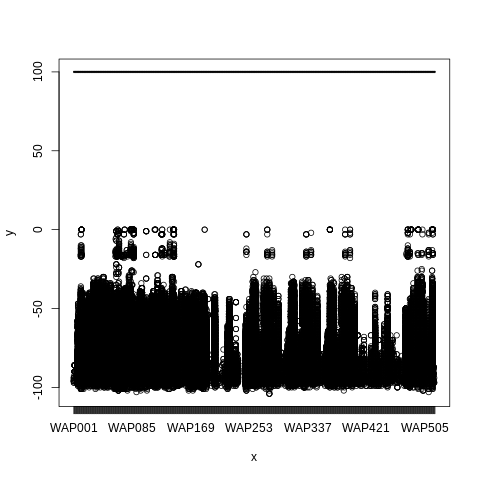

In [58]:
%%R
plot( x = as.factor(rep(colnames(dataTraining)[1:520],nrow(dataTraining))), y = c(t(dataTraining[,1:520])))

**Replacing outliers between (0 and -40) with -50**

In [0]:
%%R
for (i in c(1:nrow(dataTraining))) {
  sapply(dataTraining[i, 1:520], function(x) {if (max(x) > -40)   replace(x, x > -40, -50)})
}

**Converting data type from dataTraining & dataValidation**

In [0]:
%%R
dataTraining$LONGITUDE <- as.numeric(dataTraining$LONGITUDE)
dataTraining$LATITUDE <- as.numeric(dataTraining$LATITUDE)
dataTraining$FLOOR <- as.factor(dataTraining$FLOOR)
dataTraining$BUILDINGID <- as.factor(dataTraining$BUILDINGID)

dataValidation$LONGITUDE <- as.numeric(dataValidation$LONGITUDE)
dataValidation$LATITUDE <- as.numeric(dataValidation$LATITUDE)
dataValidation$FLOOR <- as.factor(dataValidation$FLOOR)
dataValidation$BUILDINGID <- as.factor(dataValidation$BUILDINGID)

**Removing WAPs where na = 100 / from dataTraining**

In [0]:
%%R
dataTraining <- dataTraining[,colSums(is.na(dataTraining))<nrow(dataTraining)]
dataTraining <- dataTraining[rowSums(is.na(dataTraining[ , -c(466:474)]))< (ncol(dataTraining) -9) , ]

**Adding 4 variables (BUILDINGID, FLOOR, LONGITUDE, LATITUDE) to 4 seperate datasets for easier analysis**

**Removing non-related attributes, and creating training data with WAPs and BUILDINGID**

In [0]:
%%R
trainData_building = dataTraining
trainData_building$FLOOR = NULL
trainData_building$LONGITUDE = NULL
trainData_building$LATITUDE = NULL
trainData_building$PHONEID = NULL
trainData_building$USERID = NULL
trainData_building$RELATIVEPOSITION = NULL
trainData_building$SPACEID = NULL
trainData_building$TIMESTAMP = NULL

validData_building = dataValidation
validData_building$FLOOR = NULL
validData_building$LONGITUDE = NULL
validData_building$LATITUDE = NULL
validData_building$PHONEID = NULL
validData_building$USERID = NULL
validData_building$RELATIVEPOSITION = NULL
validData_building$SPACEID = NULL
validData_building$TIMESTAMP = NULL

new_valid_building <- validData_building[,match(colnames(trainData_building), colnames(validData_building))]

**Removing non-related attributes, and creating training data with WAPs and FLOOR**

In [0]:
%%R
trainData_floor = dataTraining
trainData_floor$BUILDINGID = NULL
trainData_floor$LONGITUDE = NULL
trainData_floor$LATITUDE = NULL
trainData_floor$PHONEID = NULL
trainData_floor$USERID = NULL
trainData_floor$RELATIVEPOSITION = NULL
trainData_floor$SPACEID = NULL
trainData_floor$TIMESTAMP = NULL

validData_floor = dataValidation
validData_floor$BUILDINGID = NULL
validData_floor$LONGITUDE = NULL
validData_floor$LATITUDE = NULL
validData_floor$PHONEID = NULL
validData_floor$USERID = NULL
validData_floor$RELATIVEPOSITION = NULL
validData_floor$SPACEID = NULL
validData_floor$TIMESTAMP = NULL

new_valid_floor <- validData_floor[,match(colnames(trainData_floor), colnames(validData_floor))]

**Removing non-related attributes, and creating training data with WAPs and LONGITUDE**

In [0]:
%%R
trainData_longitude = dataTraining
trainData_longitude$BUILDINGID = NULL
trainData_longitude$FLOOR = NULL
trainData_longitude$LATITUDE = NULL
trainData_longitude$PHONEID = NULL
trainData_longitude$USERID = NULL
trainData_longitude$RELATIVEPOSITION = NULL
trainData_longitude$SPACEID = NULL
trainData_longitude$TIMESTAMP = NULL

validData_longitude = dataValidation
validData_longitude$BUILDINGID = NULL
validData_longitude$FLOOR = NULL
validData_longitude$LATITUDE = NULL
validData_longitude$PHONEID = NULL
validData_longitude$USERID = NULL
validData_longitude$RELATIVEPOSITION = NULL
validData_longitude$SPACEID = NULL
validData_longitude$TIMESTAMP = NULL

new_valid_longitude <- validData_longitude[,match(colnames(trainData_longitude), colnames(validData_longitude))]

**Removing non-related attributes, and creating training data with WAPs and LATITUDE**

In [0]:
%%R
trainData_latitude = dataTraining
trainData_latitude$BUILDINGID = NULL
trainData_latitude$FLOOR = NULL
trainData_latitude$LONGITUDE = NULL
trainData_latitude$PHONEID = NULL
trainData_latitude$USERID = NULL
trainData_latitude$RELATIVEPOSITION = NULL
trainData_latitude$SPACEID = NULL
trainData_latitude$TIMESTAMP = NULL

validData_latitude = dataValidation
validData_latitude$BUILDINGID = NULL
validData_latitude$FLOOR = NULL
validData_latitude$LONGITUDE = NULL
validData_latitude$PHONEID = NULL
validData_latitude$USERID = NULL
validData_latitude$RELATIVEPOSITION = NULL
validData_latitude$SPACEID = NULL
validData_latitude$TIMESTAMP = NULL

new_valid_latitude <- validData_latitude[,match(colnames(trainData_latitude), colnames(validData_latitude))]

**Splitting data into trainSet & testSet for each round of running a new model**

###K-NN Model on BUILDING

In [0]:
%%R
set.seed(123)
trainData1 <- createDataPartition(y = trainData_building$BUILDINGID, p = 0.75, list = FALSE)
trainSet1 <- trainData_building[trainData1,]
testSet1 <- trainData_building[-trainData1,]

**Fit Control / Cross Validation / K-NN model**

In [67]:
%%R
fitControl <- trainControl(method = "repeatedcv", number = 5, repeats = 1)
knn_fit_building <- train((BUILDINGID ~ .), 
                          data = trainSet1, 
                          method = "knn", 
                          trControl = fitControl, 
                          tuneGrid = expand.grid(k = 5))
knn_fit_building

k-Nearest Neighbors 

14953 samples
  520 predictor
    3 classes: '0', '1', '2' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 1 times) 
Summary of sample sizes: 11962, 11962, 11963, 11962, 11963 
Resampling results:

  Accuracy   Kappa   
  0.9967231  0.994848

Tuning parameter 'k' was held constant at a value of 5


**Testing k-NN model on testSet1**

In [68]:
%%R
knn_Pred_building <- predict(knn_fit_building, newdata = testSet1)
knn_CM_building_tes <- confusionMatrix(knn_Pred_building, testSet1$BUILDINGID)
knn_CM_building_tes

Confusion Matrix and Statistics

          Reference
Prediction    0    1    2
         0 1309    0    0
         1    3 1294    8
         2    0    5 2365

Overall Statistics
                                          
               Accuracy : 0.9968          
                 95% CI : (0.9948, 0.9982)
    No Information Rate : 0.4761          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.995           
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 0 Class: 1 Class: 2
Sensitivity            0.9977   0.9962   0.9966
Specificity            1.0000   0.9970   0.9981
Pos Pred Value         1.0000   0.9916   0.9979
Neg Pred Value         0.9992   0.9986   0.9969
Prevalence             0.2632   0.2606   0.4761
Detection Rate         0.2626   0.2596   0.4745
Detection Prevalence   0.2626   0.2618   0.4755
Balanced Accuracy      0.9989

**Testing k-NN model on dataValidation**

In [69]:
%%R
knn_Pred_building_val <- predict(knn_fit_building, newdata = validData_building)
knn_CM_building_val <- confusionMatrix(knn_Pred_building_val, validData_building$BUILDINGID)
knn_CM_building_val

Confusion Matrix and Statistics

          Reference
Prediction   0   1   2
         0 533   0   0
         1   1 307   5
         2   2   0 263

Overall Statistics
                                          
               Accuracy : 0.9928          
                 95% CI : (0.9859, 0.9969)
    No Information Rate : 0.4824          
    P-Value [Acc > NIR] : < 2e-16         
                                          
                  Kappa : 0.9886          
                                          
 Mcnemar's Test P-Value : 0.04601         

Statistics by Class:

                     Class: 0 Class: 1 Class: 2
Sensitivity            0.9944   1.0000   0.9813
Specificity            1.0000   0.9925   0.9976
Pos Pred Value         1.0000   0.9808   0.9925
Neg Pred Value         0.9948   1.0000   0.9941
Prevalence             0.4824   0.2763   0.2412
Detection Rate         0.4797   0.2763   0.2367
Detection Prevalence   0.4797   0.2817   0.2385
Balanced Accuracy      0.9972   0.9963   

###k-NN Model on FLOOR

In [0]:
%%R
set.seed(123)
trainData2 <- createDataPartition(y = trainData_floor$FLOOR, p = 0.75, list = FALSE)
trainSet2 <- trainData_floor [trainData2,]
testSet2 <- trainData_floor [-trainData2,]

**Fit Control / Cross Validation / K-NN model**

In [71]:
%%R
fitControl <- trainControl(method = "repeatedcv", number = 5, repeats = 1)
knn_fit_floor <- train((FLOOR ~ .), 
                       data = trainSet2, 
                       method = "knn", 
                       trControl = fitControl, 
                       tuneGrid = expand.grid(k = 5))
knn_fit_floor

k-Nearest Neighbors 

14954 samples
  520 predictor
    5 classes: '0', '1', '2', '3', '4' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 1 times) 
Summary of sample sizes: 11962, 11965, 11963, 11962, 11964 
Resampling results:

  Accuracy  Kappa    
  0.958607  0.9464401

Tuning parameter 'k' was held constant at a value of 5


**Testing k-NN model on testSet2**

In [72]:
%%R
knn_Pred_floor <- predict(knn_fit_floor, newdata = testSet2)
knn_CM_floor_val <- confusionMatrix(knn_Pred_floor, testSet2$FLOOR)
knn_CM_floor_val

Confusion Matrix and Statistics

          Reference
Prediction    0    1    2    3    4
         0 1075   67    2    2    0
         1    6 1169   20    1    0
         2    1   12 1026   13    0
         3   10    2   56 1246    0
         4    0    0    0    0  275

Overall Statistics
                                          
               Accuracy : 0.9615          
                 95% CI : (0.9557, 0.9666)
    No Information Rate : 0.2533          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9501          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.9844   0.9352   0.9293   0.9873  1.00000
Specificity            0.9818   0.9928   0.9933   0.9817  1.00000
Pos Pred Value         0.9380   0.9774   0.9753   0.9482  1.00000
Neg Pred Value         0.9956   0.978

**Testing k-NN model on validData_floor**

In [73]:
%%R
knn_Pred_floor_val <- predict(knn_fit_floor, newdata = validData_floor)
knn_CM_floor_val <- confusionMatrix(knn_Pred_floor_val, validData_floor$FLOOR)
knn_CM_floor_val

Confusion Matrix and Statistics

          Reference
Prediction   0   1   2   3   4
         0 116  68   8   4   2
         1   8 324  13   0   0
         2   6  59 202   7   0
         3   2  11  83 159  15
         4   0   0   0   2  22

Overall Statistics
                                          
               Accuracy : 0.7408          
                 95% CI : (0.7139, 0.7663)
    No Information Rate : 0.4158          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6513          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.8788   0.7013   0.6601   0.9244   0.5641
Specificity            0.9162   0.9676   0.9106   0.8818   0.9981
Pos Pred Value         0.5859   0.9391   0.7372   0.5889   0.9167
Neg Pred Value         0.9825   0.8198   0.8757   0.9845   0.9844
P

###k-NN Model on Longitude

In [0]:
%%R
set.seed(123)
trainData3 <- createDataPartition(y = trainData_longitude$LONGITUDE, p = 0.75, list = FALSE)
trainSet3 <- trainData_longitude [trainData3,]
testSet3 <- trainData_longitude [-trainData3,]

**Fit Control / Cross Validation / K-NN model**

In [75]:
%%R
fitControl <- trainControl(method = "repeatedcv", number = 5, repeats = 1)
knn_fit_longitude <- train((LONGITUDE ~ .), 
                           data = trainSet3, 
                           method = "knn", 
                           trControl = fitControl, 
                           tuneGrid = expand.grid(k = 5))
knn_fit_longitude

k-Nearest Neighbors 

14955 samples
  520 predictor

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 1 times) 
Summary of sample sizes: 11963, 11965, 11964, 11963, 11965 
Resampling results:

  RMSE     Rsquared   MAE     
  10.9136  0.9920967  4.458733

Tuning parameter 'k' was held constant at a value of 5


**Testing k-NN model on testSet3**

In [76]:
%%R
knn_Pred_longitude <- predict(knn_fit_longitude, newdata = testSet3)
postResample(knn_Pred_longitude, testSet3$LONGITUDE)

     RMSE  Rsquared       MAE 
9.0799665 0.9945795 3.8540288 


**Testing k-NN model on validData_longitude**

In [78]:
%%R
knn_Pred_longitude_val <- predict(knn_fit_longitude, newdata = validData_longitude)
postResample(knn_Pred_longitude_val, validData_longitude$LONGITUDE)

      RMSE   Rsquared        MAE 
20.1294736  0.9720978 10.1879940 


###k-NN Model on Latitude

In [0]:
%%R
set.seed(123)
trainData4 <- createDataPartition(y = trainData_latitude$LATITUDE, p = 0.75, list = FALSE)
trainSet4 <- trainData_latitude [trainData4,]
testSet4 <- trainData_latitude [-trainData4,]

**Fit Control / Cross Validation / K-NN model**

In [80]:
%%R
fitControl <- trainControl(method = "repeatedcv", number = 5, repeats = 1)
knn_fit_latitude <- train((LATITUDE ~ .), 
                          data = trainSet4, 
                          method = "knn", 
                          trControl = fitControl, 
                          tuneGrid = expand.grid(k = 4))
knn_fit_latitude

k-Nearest Neighbors 

14953 samples
  520 predictor

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 1 times) 
Summary of sample sizes: 11963, 11962, 11964, 11962, 11961 
Resampling results:

  RMSE     Rsquared   MAE     
  7.06613  0.9887733  3.226847

Tuning parameter 'k' was held constant at a value of 4


**Testing k-NN model on testSet4**

In [81]:
%%R
knn_Pred_latitude <- predict(knn_fit_latitude, newdata = testSet4)
postResample(knn_Pred_latitude, testSet4$LATITUDE)

     RMSE  Rsquared       MAE 
6.8364082 0.9897574 2.9754925 


**Testing k-NN model on validData_latitude**

In [82]:
%%R
knn_Pred_latitude_val <- predict(knn_fit_latitude, newdata = validData_latitude)
postResample(knn_Pred_latitude_val, validData_latitude$LATITUDE)

      RMSE   Rsquared        MAE 
16.2498909  0.9477929  8.7700491 


###Random Forest Model on BUILDING

In [0]:
%%R
set.seed(123)
trainData5 <- createDataPartition(y = trainData_building$BUILDINGID, p = 0.75, list = FALSE)
trainSet5 <- trainData_building [trainData5,]
testSet5 <- trainData_building [-trainData5,]

**Fit Control / Cross Validation / Random Forest model**

In [84]:
%%R
fitControl <- trainControl(method = "repeatedcv", number = 5, repeats = 1)
RF_fit_building <- randomForest(BUILDINGID~., 
                                data = trainSet5,
                                ntree = 100,
                                mtry = 2,
                                do.trace = TRUE,
                                trControl = fitControl,
                                imporve = 0.05,
                                nodesize = 5)
RF_fit_building

ntree      OOB      1      2      3
    1:  16.76% 11.32%  1.26% 28.31%
    2:  25.57%  5.24% 28.07% 35.51%
    3:  19.20%  3.23% 22.65% 26.11%
    4:  23.46% 20.70% 34.91% 18.75%
    5:  20.35% 19.71% 33.09% 13.78%
    6:  20.53% 13.95% 35.70% 15.87%
    7:  22.11% 22.08% 41.45% 11.56%
    8:  19.55% 23.05% 33.35% 10.08%
    9:  17.32% 19.65% 33.07%  7.43%
   10:  16.10% 14.62% 33.19%  7.58%
   11:  13.74% 13.42% 27.84%  6.20%
   12:  12.76% 10.73% 27.53%  5.80%
   13:  11.04%  8.46% 25.70%  4.45%
   14:   9.16%  6.95% 21.02%  3.90%
   15:   8.04%  6.25% 18.40%  3.36%
   16:   8.37%  6.84% 20.73%  2.46%
   17:   8.33%  7.17% 21.03%  2.02%
   18:   7.11%  6.30% 17.20%  2.04%
   19:   6.40%  5.54% 15.89%  1.67%
   20:   5.67%  4.75% 14.22%  1.50%
   21:   5.88%  4.80% 15.76%  1.07%
   22:   5.55%  4.80% 14.93%  0.83%
   23:   6.15%  5.23% 17.12%  0.66%
   24:   5.44%  4.98% 14.75%  0.60%
   25:   6.34%  6.15% 17.19%  0.51%
   26:   6.09%  5.49% 17.17%  0.37%
   27:   5.59%  5.31% 15.35%

**Testing Random Forest model on testSet5**

In [85]:
%%R
RF_Pred_building <- predict(RF_fit_building, newdata = testSet5)
RF_CM_building <- confusionMatrix(RF_Pred_building, testSet5$BUILDINGID)
RF_CM_building

Confusion Matrix and Statistics

          Reference
Prediction    0    1    2
         0 1312    0    0
         1    0 1252    0
         2    0   47 2373

Overall Statistics
                                          
               Accuracy : 0.9906          
                 95% CI : (0.9875, 0.9931)
    No Information Rate : 0.4761          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9851          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 0 Class: 1 Class: 2
Sensitivity            1.0000   0.9638   1.0000
Specificity            1.0000   1.0000   0.9820
Pos Pred Value         1.0000   1.0000   0.9806
Neg Pred Value         1.0000   0.9874   1.0000
Prevalence             0.2632   0.2606   0.4761
Detection Rate         0.2632   0.2512   0.4761
Detection Prevalence   0.2632   0.2512   0.4856
Balanced Accuracy      1.0000

**Testing Random Forest model on validData_building**

In [86]:
%%R
RF_Pred_building_val <- predict(RF_fit_building, newdata = validData_building)
RF_CM_building_val <- confusionMatrix(RF_Pred_building_val, validData_building$BUILDINGID)
RF_CM_building_val

Confusion Matrix and Statistics

          Reference
Prediction   0   1   2
         0 535   0   0
         1   0 289   0
         2   1  18 268

Overall Statistics
                                          
               Accuracy : 0.9829          
                 95% CI : (0.9734, 0.9897)
    No Information Rate : 0.4824          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.973           
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 0 Class: 1 Class: 2
Sensitivity            0.9981   0.9414   1.0000
Specificity            1.0000   1.0000   0.9775
Pos Pred Value         1.0000   1.0000   0.9338
Neg Pred Value         0.9983   0.9781   1.0000
Prevalence             0.4824   0.2763   0.2412
Detection Rate         0.4815   0.2601   0.2412
Detection Prevalence   0.4815   0.2601   0.2583
Balanced Accuracy      0.9991   0.9707   

###Random Forest Model on FLOOR

In [0]:
%%R
set.seed(123)
trainData6 <- createDataPartition(y = trainData_floor$FLOOR, p = 0.75, list = FALSE)
trainSet6 <- trainData_floor [trainData6,]
testSet6 <- trainData_floor [-trainData6,]

**Fit Control / Cross Validation / Random Forest model**

In [88]:
%%R
fitControl <- trainControl(method = "repeatedcv", number = 5, repeats = 1)
RF_fit_floor <- randomForest(FLOOR~., 
                             data = trainSet6,
                             ntree = 100,
                             mtry = 2,
                             do.trace = TRUE,
                             trControl = fitControl,
                             imporve = 0.05,
                             nodesize = 5)
RF_fit_floor

ntree      OOB      1      2      3      4      5
    1:  53.75% 54.62% 50.94% 78.95% 29.13% 79.13%
    2:  56.37% 34.82% 50.22% 83.61% 50.09% 90.31%
    3:  55.21% 40.72% 49.16% 82.30% 41.83% 92.52%
    4:  54.55% 41.05% 55.00% 82.86% 33.33% 89.40%
    5:  53.37% 44.02% 47.22% 83.60% 34.29% 84.06%
    6:  51.66% 38.40% 49.32% 76.55% 36.51% 84.58%
    7:  52.58% 42.67% 52.30% 81.17% 29.48% 84.03%
    8:  51.69% 46.47% 48.25% 79.75% 28.39% 81.74%
    9:  52.21% 51.15% 48.40% 82.75% 23.48% 82.98%
   10:  50.73% 47.75% 47.58% 81.48% 22.57% 82.48%
   11:  49.37% 45.37% 48.27% 79.90% 19.15% 85.91%
   12:  49.89% 45.83% 50.43% 81.20% 17.08% 88.11%
   13:  51.46% 49.25% 55.45% 82.74% 13.64% 89.94%
   14:  50.28% 48.42% 51.30% 81.71% 14.20% 92.36%
   15:  49.08% 44.98% 50.81% 82.16% 12.22% 93.70%
   16:  47.68% 42.40% 50.00% 82.04% 10.30% 91.77%
   17:  46.92% 39.33% 50.55% 82.59%  9.46% 89.36%
   18:  46.45% 39.15% 46.09% 84.02% 10.91% 89.36%
   19:  45.63% 38.37% 44.12% 83.18% 11.38% 87.67%


**Testing Random Forest model on testSet6**

In [89]:
%%R
RF_Pred_floor <- predict(RF_fit_floor, newdata = testSet6)
RF_CM_floor <- confusionMatrix(RF_Pred_floor, testSet6$FLOOR)
RF_CM_floor

Confusion Matrix and Statistics

          Reference
Prediction    0    1    2    3    4
         0  833  112   16    0    0
         1  194  963  203    9    0
         2    1   20  205    4    0
         3   64  155  680 1249  275
         4    0    0    0    0    0

Overall Statistics
                                          
               Accuracy : 0.6522          
                 95% CI : (0.6388, 0.6654)
    No Information Rate : 0.2533          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.5396          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.7628   0.7704  0.18569   0.9897  0.00000
Specificity            0.9671   0.8912  0.99356   0.6845  1.00000
Pos Pred Value         0.8668   0.7034  0.89130   0.5155      NaN
Neg Pred Value         0.9356   0.920

**Testing Random Forest model on validData_floor**

In [90]:
%%R
RF_Pred_floor_val <- predict(RF_fit_floor, newdata = validData_floor)
RF_CM_floor_val <- confusionMatrix(RF_Pred_floor_val, validData_floor$FLOOR)
RF_CM_floor_val

Confusion Matrix and Statistics

          Reference
Prediction   0   1   2   3   4
         0  78  31   0   0   1
         1  33 360  27   2   0
         2   0  10  43   2   0
         3  21  61 236 168  38
         4   0   0   0   0   0

Overall Statistics
                                          
               Accuracy : 0.5842          
                 95% CI : (0.5545, 0.6133)
    No Information Rate : 0.4158          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.4408          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity           0.59091   0.7792   0.1405   0.9767   0.0000
Specificity           0.96731   0.9045   0.9851   0.6209   1.0000
Pos Pred Value        0.70909   0.8531   0.7818   0.3206      NaN
Neg Pred Value        0.94605   0.8520   0.7509   0.9932   0.9649
P

###Random Forest Model on LONGITUDE

In [0]:
%%R
set.seed(123)
trainData7 <- createDataPartition(y = trainData_longitude$LONGITUDE, p = 0.75, list = FALSE)
trainSet7 <- trainData_longitude [trainData7,]
testSet7 <- trainData_longitude [-trainData7,]

**Fit Control / Cross Validation / Random Forest model**

In [92]:
%%R
fitControl <- trainControl(method = "repeatedcv", number = 5, repeats = 1)
RF_fit_longitude <- randomForest(LONGITUDE~., 
                                 data = trainSet7,
                                 ntree = 100,
                                 mtry = 2,
                                 do.trace = TRUE,
                                 trControl = fitControl,
                                 imporve = 0.05,
                                 nodesize = 5)
RF_fit_longitude

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
   1 |     2266    14.87 |
   2 |     3743    24.57 |
   3 |     2980    19.56 |
   4 |     3394    22.28 |
   5 |     2980    19.56 |
   6 |     3514    23.07 |
   7 |     3818    25.06 |
   8 |     3605    23.66 |
   9 |     4305    28.26 |
  10 |     4228    27.75 |
  11 |     3800    24.95 |
  12 |     3597    23.62 |
  13 |     3488    22.90 |
  14 |     3939    25.86 |
  15 |     4239    27.83 |
  16 |     4184    27.47 |
  17 |     3999    26.25 |
  18 |     3842    25.22 |
  19 |     3878    25.46 |
  20 |     3659    24.02 |
  21 |     3691    24.23 |
  22 |     3712    24.37 |
  23 |     3882    25.49 |
  24 |     4027    26.44 |
  25 |     3851    25.28 |
  26 |     3867    25.38 |
  27 |     3951    25.94 |
  28 |     3771    24.75 |
  29 |     3851    25.28 |
  30 |     3683    24.18 |
  31 |     3711    24.36 |
  32 |     3592    23.58 |
  33 |     3472    22.79 |
  34 |     3487    22.89 |
  35 |     3406    22.36 |
 

**Testing Random Forest model on testSet7**

In [93]:
%%R
RF_Pred_longitude <- predict(RF_fit_longitude, newdata = testSet7)
postResample(RF_Pred_longitude, testSet7$LONGITUDE)

      RMSE   Rsquared        MAE 
57.0550775  0.9460101 48.7153066 


**Testing Random Forest model on validData_longitude**

In [94]:
%%R
RF_Pred_longitude_val <- predict(RF_fit_longitude, newdata = validData_longitude)
postResample(RF_Pred_longitude_val, validData_longitude$LONGITUDE)

     RMSE  Rsquared       MAE 
65.072589  0.934797 56.944552 


###Random Forest Model on LATITUDE

In [0]:
%%R
set.seed(123)
trainData8 <- createDataPartition(y = trainData_latitude$LATITUDE, p = 0.75, list = FALSE)
trainSet8 <- trainData_latitude [trainData8,]
testSet8 <- trainData_latitude [-trainData8,]

**Fit Control / Cross Validation / Random Forest model**

In [96]:
%%R
fitControl <- trainControl(method = "repeatedcv", number = 5, repeats = 1)
RF_fit_latitude <- randomForest(LATITUDE~., 
                                data = trainSet8,
                                ntree = 100,
                                mtry = 2,
                                do.trace = TRUE,
                                trControl = fitControl,
                                imporve = 0.05,
                                nodesize = 5)
RF_fit_latitude

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
   1 |     1967    44.16 |
   2 |     1595    35.81 |
   3 |     2216    49.74 |
   4 |     2297    51.55 |
   5 |     2067    46.40 |
   6 |     2197    49.32 |
   7 |     2188    49.11 |
   8 |     1961    44.00 |
   9 |     1678    37.66 |
  10 |     1546    34.71 |
  11 |     1594    35.78 |
  12 |     1453    32.62 |
  13 |     1421    31.89 |
  14 |     1411    31.67 |
  15 |     1376    30.88 |
  16 |     1292    29.01 |
  17 |     1284    28.82 |
  18 |     1301    29.21 |
  19 |     1400    31.42 |
  20 |     1491    33.46 |
  21 |     1451    32.56 |
  22 |     1424    31.97 |
  23 |     1492    33.49 |
  24 |     1459    32.76 |
  25 |     1439    32.31 |
  26 |     1449    32.52 |
  27 |     1447    32.48 |
  28 |     1422    31.92 |
  29 |     1426    32.01 |
  30 |     1436    32.23 |
  31 |     1413    31.71 |
  32 |     1451    32.56 |
  33 |     1423    31.95 |
  34 |     1371    30.78 |
  35 |     1345    30.20 |
 

**Testing Random Forest model on testSet**

In [97]:
%%R
RF_Pred_latitude <- predict(RF_fit_latitude, newdata = testSet8)
postResample(RF_Pred_latitude, testSet8$LATITUDE)

      RMSE   Rsquared        MAE 
31.5232179  0.9157688 24.0524292 


**Testing Random Forest model on validData_latitude**

In [98]:
%%R
RF_Pred_latitude_val <- predict(RF_fit_latitude, newdata = validData_latitude)
postResample(RF_Pred_latitude_val, validData_latitude$LATITUDE)

      RMSE   Rsquared        MAE 
37.1086009  0.9062632 29.8384152 


###Gradient Boost Trees Model on BUILDING

In [0]:
%%R
set.seed(123)
trainData9 <- createDataPartition(y = trainData_building$BUILDINGID, p = 0.75, list = FALSE)
trainSet9 <- trainData_building [trainData9,]
testSet9 <- trainData_building [-trainData9,]

**Fit Control / Cross Validation / Gradient Boosting Trees**

In [100]:
%%R
fitControl <- trainControl(method = "repeatedcv", number = 5, repeats = 1)
myGrid <- expand.grid(n.trees = c(250), 
                      interaction.depth = 1, 
                      shrinkage = c(0.1),
                      n.minobsinnode = 20)

GB_fit_building <- train((BUILDINGID ~ .), 
                         data = trainSet9, 
                         method = "gbm",
                         trControl = fitControl,
                         tuneGrid = myGrid)
GB_fit_building

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986            -nan     0.1000    0.1278
     2        1.0088            -nan     0.1000    0.1149
     3        0.9303            -nan     0.1000    0.0910
     4        0.8689            -nan     0.1000    0.0849
     5        0.8126            -nan     0.1000    0.0692
     6        0.7665            -nan     0.1000    0.0640
     7        0.7241            -nan     0.1000    0.0547
     8        0.6871            -nan     0.1000    0.0522
     9        0.6531            -nan     0.1000    0.0460
    10        0.6226            -nan     0.1000    0.0432
    20        0.4144            -nan     0.1000    0.0219
    40        0.2289            -nan     0.1000    0.0091
    60        0.1446            -nan     0.1000    0.0041
    80        0.0987            -nan     0.1000    0.0025
   100        0.0707            -nan     0.1000    0.0015
   120        0.0527            -nan     0.1000    0.0007
   140        

**Testing Gradient Boosting Trees model on testSet9**

In [101]:
%%R
GB_Pred_building <- predict(GB_fit_building, newdata = testSet9)
GB_CM_building <- confusionMatrix(GB_Pred_building, testSet9$BUILDINGID)
GB_CM_building

Confusion Matrix and Statistics

          Reference
Prediction    0    1    2
         0 1312    0    0
         1    0 1299   12
         2    0    0 2361

Overall Statistics
                                          
               Accuracy : 0.9976          
                 95% CI : (0.9958, 0.9988)
    No Information Rate : 0.4761          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9962          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 0 Class: 1 Class: 2
Sensitivity            1.0000   1.0000   0.9949
Specificity            1.0000   0.9967   1.0000
Pos Pred Value         1.0000   0.9908   1.0000
Neg Pred Value         1.0000   1.0000   0.9954
Prevalence             0.2632   0.2606   0.4761
Detection Rate         0.2632   0.2606   0.4737
Detection Prevalence   0.2632   0.2630   0.4737
Balanced Accuracy      1.0000

**Testing Gradient Boosting Trees model on validData_building**

In [102]:
%%R
GB_Pred_building_val <- predict(GB_fit_building, newdata = validData_building)
GB_CM_building_val <- confusionMatrix(GB_Pred_building_val, validData_building$BUILDINGID)
GB_CM_building_val

Confusion Matrix and Statistics

          Reference
Prediction   0   1   2
         0 534   1   0
         1   2 306   0
         2   0   0 268

Overall Statistics
                                          
               Accuracy : 0.9973          
                 95% CI : (0.9921, 0.9994)
    No Information Rate : 0.4824          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9957          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 0 Class: 1 Class: 2
Sensitivity            0.9963   0.9967   1.0000
Specificity            0.9983   0.9975   1.0000
Pos Pred Value         0.9981   0.9935   1.0000
Neg Pred Value         0.9965   0.9988   1.0000
Prevalence             0.4824   0.2763   0.2412
Detection Rate         0.4806   0.2754   0.2412
Detection Prevalence   0.4815   0.2772   0.2412
Balanced Accuracy      0.9973   0.9971   

###radient Boost Trees Model on FLOOR

In [0]:
%%R
set.seed(123)
trainData10 <- createDataPartition(y = trainData_floor$FLOOR, p = 0.75, list = FALSE)
trainSet10 <- trainData_floor [trainData10,]
testSet10 <- trainData_floor [-trainData10,]

**Fit Control / Cross Validation / Gradient Boosting Trees model**

In [104]:
%%R
fitControl <- trainControl(method = "repeatedcv", number = 5, repeats = 1)
myGrid <- expand.grid(n.trees = c(250), 
                      interaction.depth = 1, 
                      shrinkage = c(0.1),
                      n.minobsinnode = 20)

GB_fit_floor <- train((FLOOR ~ .), 
                      data = trainSet10, 
                      method = "gbm",
                      trControl = fitControl,
                      tuneGrid = myGrid)
GB_fit_floor

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.6094            -nan     0.1000    0.0825
     2        1.5527            -nan     0.1000    0.0705
     3        1.5051            -nan     0.1000    0.0567
     4        1.4662            -nan     0.1000    0.0599
     5        1.4281            -nan     0.1000    0.0450
     6        1.3970            -nan     0.1000    0.0410
     7        1.3694            -nan     0.1000    0.0384
     8        1.3438            -nan     0.1000    0.0339
     9        1.3203            -nan     0.1000    0.0358
    10        1.2972            -nan     0.1000    0.0290
    20        1.1432            -nan     0.1000    0.0170
    40        0.9689            -nan     0.1000    0.0087
    60        0.8645            -nan     0.1000    0.0062
    80        0.7871            -nan     0.1000    0.0048
   100        0.7267            -nan     0.1000    0.0032
   120        0.6757            -nan     0.1000    0.0020
   140        

**Testing Gradient Boosting Trees model on testSet10**

In [105]:
%%R
GB_Pred_floor <- predict(GB_fit_floor, newdata = testSet10)
GB_CM_floor <- confusionMatrix(GB_Pred_floor, testSet10$FLOOR)
GB_CM_floor

Confusion Matrix and Statistics

          Reference
Prediction    0    1    2    3    4
         0  995   82    2    1    0
         1   83 1103   61    7    0
         2    4   57  910   95    0
         3   10    8  131 1158    8
         4    0    0    0    1  267

Overall Statistics
                                          
               Accuracy : 0.8896          
                 95% CI : (0.8806, 0.8982)
    No Information Rate : 0.2533          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.8571          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.9112   0.8824   0.8243   0.9176  0.97091
Specificity            0.9782   0.9595   0.9598   0.9578  0.99979
Pos Pred Value         0.9213   0.8796   0.8537   0.8806  0.99627
Neg Pred Value         0.9751   0.960

**Testing Gradient Boost Trees model on validData_floor**

In [106]:
%%R
GB_Pred_floor_val <- predict(GB_fit_floor, newdata = validData_floor)
GB_CM_floor_val <- confusionMatrix(GB_Pred_floor_val, validData_floor$FLOOR)
GB_CM_floor_val

Confusion Matrix and Statistics

          Reference
Prediction   0   1   2   3   4
         0 108  32   1   0   1
         1  14 336  22   2   0
         2   4  73 202  18   0
         3   6  21  81 150  19
         4   0   0   0   2  19

Overall Statistics
                                          
               Accuracy : 0.7336          
                 95% CI : (0.7065, 0.7594)
    No Information Rate : 0.4158          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.636           
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity           0.81818   0.7273   0.6601   0.8721   0.4872
Specificity           0.96527   0.9414   0.8820   0.8647   0.9981
Pos Pred Value        0.76056   0.8984   0.6801   0.5415   0.9048
Neg Pred Value        0.97523   0.8290   0.8722   0.9736   0.9817
P

###Gradient Boosting Trees Model on LONGITUDE

In [0]:
%%R
set.seed(123)
trainData11 <- createDataPartition(y = trainData_longitude$LONGITUDE, p = 0.75, list = FALSE)
trainSet11 <- trainData_longitude [trainData11,]
testSet11 <- trainData_longitude [-trainData11,]

**Fit Control / Cross Validation / Gradient Boosting Trees model**

In [108]:
%%R
fitControl <- trainControl(method = "repeatedcv", number = 5, repeats = 1)
myGrid <- expand.grid(n.trees = c(250), 
                      interaction.depth = 1, 
                      shrinkage = c(0.1),
                      n.minobsinnode = 20)

GB_fit_longitude <- train((LONGITUDE ~ .), 
                          data = trainSet11, 
                          method = "gbm",
                          trControl = fitControl,
                          tuneGrid = myGrid)

GB_fit_longitude

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1    14326.9068            -nan     0.1000  910.6689
     2    13594.2799            -nan     0.1000  731.1139
     3    12900.0698            -nan     0.1000  694.6637
     4    12312.5212            -nan     0.1000  584.4628
     5    11752.0569            -nan     0.1000  553.1960
     6    11208.0325            -nan     0.1000  525.5582
     7    10728.7305            -nan     0.1000  467.6907
     8    10291.3228            -nan     0.1000  419.2620
     9     9850.9217            -nan     0.1000  423.8261
    10     9435.3835            -nan     0.1000  407.1524
    20     6591.8938            -nan     0.1000  216.3081
    40     3998.7307            -nan     0.1000   77.9421
    60     2893.4980            -nan     0.1000   38.9640
    80     2304.2296            -nan     0.1000   22.4550
   100     1953.7334            -nan     0.1000   15.0984
   120     1729.0242            -nan     0.1000    8.6093
   140     157

**Testing Gradient Boosting Trees model on testSet11**

In [109]:
%%R
GB_Pred_longitude <- predict(GB_fit_longitude, newdata = testSet11)
postResample(GB_Pred_longitude, testSet11$LONGITUDE)

      RMSE   Rsquared        MAE 
33.7746467  0.9259571 25.3327056 


**Testing Gradient Boosting Trees model on validData_longitude**

In [110]:
%%R
GB_Pred_longitude_val <- predict(GB_fit_longitude, newdata = validData_longitude)
postResample(GB_Pred_longitude_val, validData_longitude$LONGITUDE)

      RMSE   Rsquared        MAE 
48.7743665  0.8390084 37.1424232 


###Gradient Boosting Trees Model on LATITUDE

In [0]:
%%R
set.seed(123)
trainData12 <- createDataPartition(y = trainData_latitude$LATITUDE, p = 0.75, list = FALSE)
trainSet12 <- trainData_latitude [trainData12,]
testSet12 <- trainData_latitude [-trainData12,]

**Fit Control / Cross Validation / Gradient Boosting Trees model**

In [113]:
%%R
fitControl <- trainControl(method = "repeatedcv", number = 5, repeats = 1)
myGrid <- expand.grid(n.trees = c(250), 
                      interaction.depth = 1, 
                      shrinkage = c(0.1),
                      n.minobsinnode = 20)

GB_fit_latitude <- train((LATITUDE ~ .), 
                         data = trainSet12, 
                         method = "gbm",
                         trControl = fitControl,
                         tuneGrid = myGrid)
GB_fit_latitude

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1     4172.2270            -nan     0.1000  275.0199
     2     3938.6992            -nan     0.1000  226.1654
     3     3708.6361            -nan     0.1000  228.2825
     4     3508.9304            -nan     0.1000  195.9721
     5     3331.3062            -nan     0.1000  177.0088
     6     3180.6881            -nan     0.1000  150.9164
     7     3036.9072            -nan     0.1000  142.3247
     8     2907.4945            -nan     0.1000  126.3407
     9     2786.7088            -nan     0.1000  118.7196
    10     2682.9830            -nan     0.1000  101.0329
    20     1966.3617            -nan     0.1000   52.2231
    40     1297.0355            -nan     0.1000   19.6202
    60      986.8631            -nan     0.1000   11.0394
    80      811.5594            -nan     0.1000    7.0271
   100      698.6480            -nan     0.1000    4.7717
   120      623.7218            -nan     0.1000    2.8191
   140      57

**Testing Gradient Boosting Trees model on testSet12**

In [114]:
%%R
GB_Pred_latitude <- predict(GB_fit_latitude, newdata = testSet12)
postResample(GB_Pred_latitude, testSet12$LATITUDE)

      RMSE   Rsquared        MAE 
21.4669102  0.8990149 16.4030607 


**Testing Gradient Boosting Trees model on validData_latitude**

In [115]:
%%R
GB_Pred_latitude_val <- predict(GB_fit_latitude, newdata = validData_latitude)
postResample(GB_Pred_latitude_val, validData_latitude$LATITUDE)

     RMSE  Rsquared       MAE 
29.634597  0.828153 21.996729 


###Error Analysis based on Longitude & Latitude

**Detecting how far in meter are the predicted location from the original location**

In [116]:
%%R
hypotenuse(6.1935, 5.7587)

[1] 8.457072


###Combining training data with prediction data

In [119]:
%%R
trainData_3_variables = dataTraining
trainData_3_variables <- trainData_3_variables[, -c(1:465)]
trainData_3_variables <- trainData_3_variables[, -c(4:9)]

trainData_3_variables$FLOOR <- dataTraining$FLOOR
trainData_3_variables$LONGITUDE <- dataTraining$LONGITUDE
trainData_3_variables$LATITUDE <- dataTraining$LATITUDE
trainData_3_variables$ORIGIN = "Training Data"

validData_3_variables = dataValidation
validData_3_variables <- validData_3_variables[, -c(1:520)]
validData_3_variables <- validData_3_variables[, -c(4:9)]

validData_3_variables$FLOOR <- knn_Pred_floor_val
validData_3_variables$LONGITUDE <- knn_Pred_longitude_val
validData_3_variables$LATITUDE <- knn_Pred_latitude_val
validData_3_variables$ORIGIN = "Prediction Data"

bind_data <- rbind(trainData_3_variables, validData_3_variables)
bind_data <- dplyr::select(bind_data, FLOOR, LONGITUDE, LATITUDE, ORIGIN)
bind_data$ORIGIN <- as.factor(bind_data$ORIGIN)


Error in rbind(deparse.level, ...) : 
  numbers of columns of arguments do not match


###Visualization of oocation of Observations (original data & prediction data)

**Location of training data**

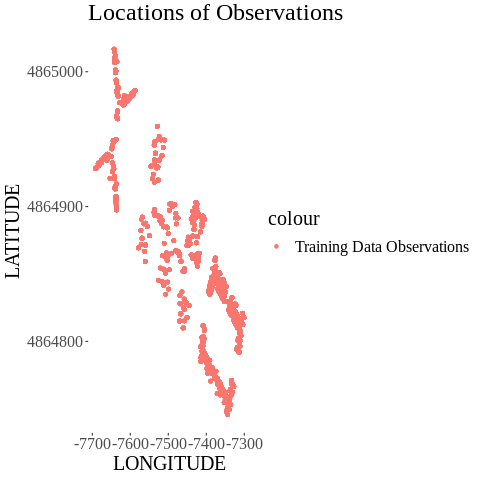

In [120]:
%%R
ggplot() +
  geom_point(data = dataTraining,
             aes(x = LONGITUDE,
                 y = LATITUDE,
                 color = "Training Data Observations")) +
  ggtitle("Locations of Observations") + theme_tufte() + 
  theme(text = element_text(size=20))

**location of validation data**

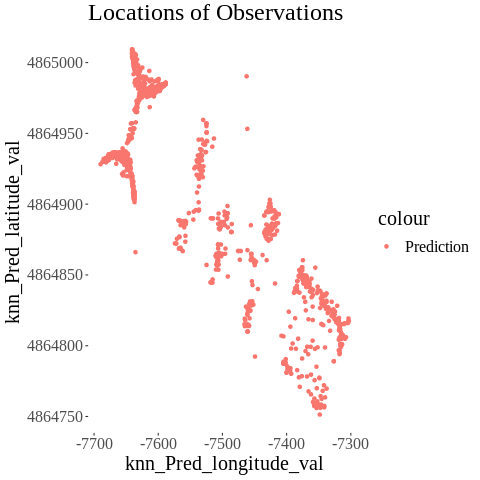

In [121]:
%%R
ggplot() +
  geom_point(data = dataValidation,
             aes(x = knn_Pred_longitude_val,
                 y = knn_Pred_latitude_val,
                 color = "Prediction")) +
  ggtitle("Locations of Observations") + theme_tufte() + theme(text = element_text(size=20))

**location of both datasets**

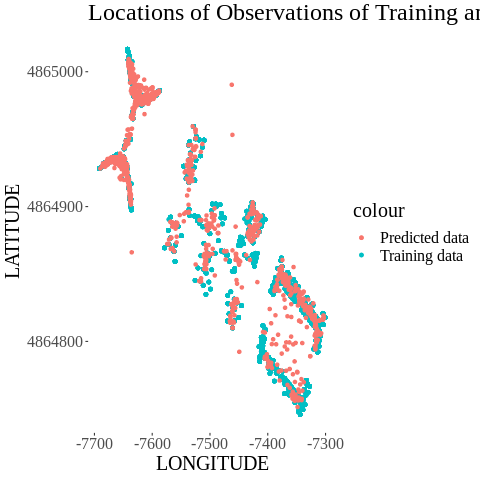

In [122]:
%%R
ggplot() +
  geom_point(data = dataTraining, aes(x = LONGITUDE, y = LATITUDE, colour = "Training data")) +
  geom_point(
    data = dataValidation,
    aes(x = knn_Pred_longitude_val, y = knn_Pred_latitude_val, colour = "Predicted data")) +
    ggtitle("Locations of Observations of Training and Prediction datasets") + 
  theme_tufte() + 
  theme(text = element_text(size = 20))

###3D plot of training data and predicted data

In [123]:
%%R
plotly::plot_ly(
  bind_data,
  x = ~ LONGITUDE,
  y = ~ LATITUDE,
  z = ~ FLOOR,
  type = "scatter3d",
  mode = "markers",
  color = ~ ORIGIN) %>%
  layout(title="3D Plot Comparing Training Data with Predicted Data",
         font=t)


Error in is.data.frame(data) : object 'bind_data' not found
